In [58]:
# Import libraries
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters  #Register pandas formatters and converters with matplotlib.
from pylab import rcParams      # for customizing matplotlib graphs.
sns.set_style("whitegrid")    

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler


In [60]:
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.svm           import SVC

In [61]:
df = pd.read_csv('heart.csv')
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace = True)

In [62]:
## chainging numerical col 'chol' into categorical column:
df['chol']= pd.cut(df['chol'], bins=[0,200,239,564], labels = [0,1,2]) #0-High, 1-Borderline high, 2-High
df['trtbps']= pd.cut(df['trtbps'], bins=[90,120,139,200], labels = [0,1,2])
df['age'] = pd.cut(df['age'], bins=[25,53,80], labels = [0, 1])
df = df.astype({'trtbps':'float64','chol':'float64', 'age':'float64'})

In [63]:
df.loc[df["cp"].isin([1,2,3]),"cp"] = 1
df.loc[df["cp"] == 0, "cp"] = 0
df["cp"] = df["cp"].astype(int)

In [64]:
df['chol_bps'] = df['chol']+df['trtbps']
df.drop(['chol','trtbps'], axis=1, inplace=True)
df


,age,sex,cp,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,chol_bps
0,1.0,1,1,1,0,150,0,2.3,0,0,1,1,3.0
1,0.0,1,1,0,1,187,0,3.5,0,0,2,1,3.0
2,0.0,0,1,0,0,172,0,1.4,2,0,2,1,2.0
3,1.0,1,1,0,1,178,0,0.8,2,0,2,1,1.0
4,1.0,0,0,0,1,163,1,0.6,2,0,2,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1.0,0,0,0,1,123,1,0.2,1,0,3,0,4.0
298,0.0,1,1,0,1,132,0,1.2,1,0,3,0,2.0
299,1.0,1,0,1,1,141,0,3.4,1,2,3,0,2.0
300,1.0,1,0,0,1,115,1,1.2,1,1,3,0,1.0


<AxesSubplot:>

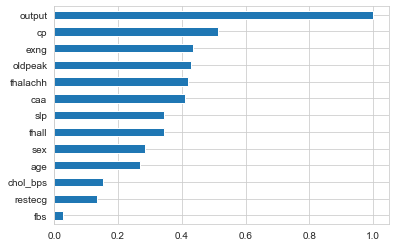

In [65]:
sns.set_style("whitegrid")
df.corr()['output'].abs().sort_values().plot(kind = 'barh')


In [66]:
# data agumentation
new_df = df.copy()
def get_data(data):
    gen_data = data
    for restecg_values in data['restecg'].unique():
        new_data = gen_data[gen_data['restecg']== restecg_values]
        thalachh_std = new_data['thalachh'].std()
        oldpeak_std = new_data['oldpeak'].std()

        for i in gen_data[gen_data['restecg']== restecg_values].index:
            if np.random.randint(2)==1:
                gen_data['thalachh'].values[i] += thalachh_std/10   
            else:
                gen_data['thalachh'].values[i] -= thalachh_std/10
            if np.random.randint(2)==1:
                gen_data['oldpeak'].values[i] += oldpeak_std/10
            else:
                gen_data['oldpeak'].values[i] -= oldpeak_std/10
    return gen_data
print(df.head())  
std_data = get_data(new_df)
std_data.head()

   age  sex  cp  fbs  restecg  thalachh  exng  oldpeak  slp  caa  thall  \
0  1.0    1   1    1        0       150     0      2.3    0    0      1   
1  0.0    1   1    0        1       187     0      3.5    0    0      2   
2  0.0    0   1    0        0       172     0      1.4    2    0      2   
3  1.0    1   1    0        1       178     0      0.8    2    0      2   
4  1.0    0   0    0        1       163     1      0.6    2    0      2   

   output  chol_bps  
0       1       3.0  
1       1       3.0  
2       1       2.0  
3       1       1.0  
4       1       2.0  


,age,sex,cp,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,chol_bps
0,1.0,1,1,1,0,152,0,2.178532,0,0,1,1,3.0
1,0.0,1,1,0,1,189,0,3.605561,0,0,2,1,3.0
2,0.0,0,1,0,0,169,0,1.278532,2,0,2,1,2.0
3,1.0,1,1,0,1,180,0,0.694439,2,0,2,1,1.0
4,1.0,0,0,0,1,160,1,0.494439,2,0,2,1,2.0


In [67]:
x= df.drop(['output'], axis=1)
y = df.output
cat_fe = [ 'sex','cp','fbs','restecg','exng','slp','caa','thall','age']
num_fe = ['thalachh','oldpeak','chol_bps']

x_train, x_test, y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=0, stratify=y)

extra_sample = std_data.sample(std_data.shape[0]//3)
x_train = pd.concat([x_train, extra_sample.drop(['output'], axis=1)])
y_train = pd.concat([y_train, extra_sample['output']])


In [68]:
s_col = ['oldpeak', 'chol_bps','thalachh']
scaler = MinMaxScaler()
for d in s_col:
    train_array = x_train[d].to_numpy()
    test_array = x_test[d].to_numpy()
    train_array = train_array.reshape(-1,1)
    test_array = test_array.reshape(-1,1)

    scaler.fit(train_array)
    x_train[d] = scaler.transform(train_array)
    x_test[d] = scaler.transform(test_array)

x_train.head()

C:\Users\rnr31\AppData\Local\Temp\ipykernel_8452\3696254945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[d] = scaler.transform(test_array)
C:\Users\rnr31\AppData\Local\Temp\ipykernel_8452\3696254945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[d] = scaler.transform(test_array)
C:\Users\rnr31\AppData\Local\Temp\ipykernel_8452\3696254945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,age,sex,cp,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,chol_bps
268,1.0,1,0,1,0,0.256,1,0.300879,0,0,3,0.75
190,1.0,1,0,0,0,0.480,1,0.405747,1,3,3,0.50
15,0.0,0,1,0,1,0.696,0,0.300879,1,0,2,0.25
223,1.0,1,0,0,1,0.440,1,0.510615,1,1,3,0.25
249,0.0,1,0,0,1,0.408,1,0.755308,1,3,3,1.00


In [69]:
x_test.to_csv('heart_test.csv')
y_test.to_csv('heart_results.csv')

In [70]:
num_4_classifiers = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-9999))
])
cat_4_classifiers = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-9999))
])
classifier_prepro = ColumnTransformer(transformers=[
    ('num', num_4_classifiers, num_fe),
    ('cat',cat_4_classifiers, cat_fe)
], remainder='drop')

In [71]:
tree_classifiers = {
  "KNN": KNeighborsClassifier(),
  "svm": SVC(kernel='linear'),
  "Logistic": LogisticRegression(),
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees": ExtraTreesClassifier(n_estimators=100),
  "Random Forest": RandomForestClassifier(n_estimators=100),
  "AdaBoost": AdaBoostClassifier(n_estimators=100),
  "Skl GBM": GradientBoostingClassifier(n_estimators=100),
  "Skl HistGBM": HistGradientBoostingClassifier(max_iter=100),
  "XGBoost": XGBClassifier(n_estimators=100),
  "LightGBM": LGBMClassifier(n_estimators=100),
  "CatBoost":  CatBoostClassifier(n_estimators=100),
}
tree_classifiers= {name:make_pipeline(classifier_prepro, model) for name, model in tree_classifiers.items()}
tree_classifiers["AdaBoost"]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant'))]),
                                                  ['thalachh', 'oldpeak',
                                                   'chol_bps']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exng', 's

In [72]:
results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

for model_name, model in tree_classifiers.items():
    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time()-start_time
    pred = model.predict(x_test)
    results = results.append({"Model":    model_name,
                            "Accuracy": accuracy_score(y_test, pred)*100,
                            "Bal Acc.": balanced_accuracy_score(y_test, pred)*100,
                            "Time":     total_time},
                            ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')


    

C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:40:17] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.053755
0:	learn: 0.6772145	total: 1.77ms	remaining: 175ms
1:	learn: 0.6602181	total: 4.09ms	remaining: 200ms
2:	learn: 0.6453996	total: 6.77ms	remaining: 219ms
3:	learn: 0.6307009	total: 9.28ms	remaining: 223ms
4:	learn: 0.6169743	total: 11.6ms	remaining: 221ms
5:	learn: 0.6028661	total: 13.6ms	remaining: 213ms
6:	learn: 0.5901227	total: 16.2ms	remaining: 215ms
7:	learn: 0.5788718	total: 18.7ms	remaining: 215ms
8:	learn: 0.5678018	total: 31.6ms	remaining: 320ms
9:	learn: 0.5576844	total: 33.7ms	remaining: 304ms
10:	learn: 0.5450822	total: 36.1ms	remaining: 292ms
11:	learn: 0.5347961	total: 38.7ms	remaining: 284ms
12:	learn: 0.5241061	total: 41.2ms	remaining: 276ms
13:	learn: 0.51

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,90.163934,90.097403,0.101064
2,XGBoost,90.163934,89.556277,0.205549
3,Random Forest,88.524590,88.041126,0.158095
4,LightGBM,88.524590,88.041126,0.142240
5,svm,86.885246,86.255411,0.011837
6,Extra Trees,86.885246,86.525974,0.170011
7,Skl HistGBM,86.885246,86.255411,0.982272
8,CatBoost,86.885246,86.525974,0.319013
9,Logistic,85.245902,84.740260,0.018980
10,KNN,83.606557,83.766234,0.033994
